In [95]:
import pandas as pd 
import sys
sys.path.append("./src")

from preprocessing import preprocess_fitness, standardize_fitness, activities_based
from algorithms import find_best_k_bootstrap, kmeans_anomaly_detection, oneClassSVM_anomaly_detection, vs_kmeans_anomalies, vs_oneClassSVM_results
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from dataset import ActivityDataset, ActivityAutoencoder, train_autoencoder, compute_reconstruction_error
from sklearn.model_selection import train_test_split


## Loading parquest data here: 

In [ ]:
fitness = pd.read_parquet("../data/pipeline/fitness.parquet")


fitness.head()

,participant_id,date,age,gender,height_cm,weight_kg,bmi,activity_type,duration_minutes,intensity,...,resting_heart_rate,blood_pressure_systolic,blood_pressure_diastolic,endurance_level,sleep_hours,stress_level,hydration_level,smoking_status,health_condition,fitness_level
0,1,2024-01-01,56,F,165.3,50.55,18.50,Dancing,42.1,Low,...,69.5,110.7,72.9,5.37,6.6,4,1.5,Never,no illness,0.04
1,1,2024-01-04,56,F,165.3,55.38,20.27,Swimming,66.9,Low,...,69.5,110.7,72.9,5.39,8.1,3,1.8,Never,no illness,0.07
2,1,2024-01-05,56,F,165.3,56.49,20.68,Swimming,20.0,Medium,...,69.5,110.7,72.9,5.42,6.2,5,2.7,Never,no illness,0.09
3,1,2024-01-07,56,F,165.3,52.23,19.12,Weight Training,23.5,Medium,...,69.5,110.7,72.9,5.44,7.2,4,2.6,Never,no illness,0.21
4,1,2024-01-09,56,F,165.3,53.96,19.75,Swimming,75.0,Medium,...,69.5,110.7,72.9,5.47,7.1,7,1.5,Never,no illness,0.33


In [97]:
fitness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687699 entries, 0 to 687698
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   participant_id            687699 non-null  category
 1   date                      687699 non-null  object  
 2   age                       687699 non-null  int32   
 3   gender                    687699 non-null  category
 4   height_cm                 687699 non-null  float64 
 5   weight_kg                 687699 non-null  float64 
 6   bmi                       687699 non-null  float64 
 7   activity_type             687699 non-null  category
 8   duration_minutes          687699 non-null  float64 
 9   intensity                 687699 non-null  category
 10  calories_burned           687699 non-null  float64 
 11  daily_steps               687699 non-null  int32   
 12  avg_heart_rate            687699 non-null  int32   
 13  resting_heart_rate        687

Cleaning fitness Data set:


In [98]:
fitness_clean = preprocess_fitness(fitness, dateEmbedding=True)

fitness_clean.describe()

,age,height_cm,weight_kg,bmi,duration_minutes,calories_burned,daily_steps,avg_heart_rate,resting_heart_rate,blood_pressure_systolic,...,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,quarter_sin,quarter_cos,dayOfYear_sin,dayOfYear_cos
count,687699.000000,687699.000000,687699.000000,687699.000000,687699.000000,687699.000000,687699.000000,687699.000000,687699.000000,687699.000000,...,6.876990e+05,6.876990e+05,687699.000000,687699.000000,687699.000000,687699.000000,6.876990e+05,6.876990e+05,687699.000000,687699.000000
mean,41.658547,168.587717,61.728182,21.663567,74.026635,15.381315,8628.396739,131.454209,70.010526,120.001241,...,9.340114e-02,-4.457579e-02,0.005291,0.004028,0.008777,-0.030205,6.063554e-02,-7.896187e-02,0.101762,-0.016024
std,13.581752,9.140818,8.547728,1.939251,35.095520,9.985564,2054.703791,17.814732,5.074552,10.008918,...,7.054844e-01,7.011294e-01,0.707432,0.706751,0.715787,0.697611,7.100881e-01,6.970400e-01,0.704580,0.702108
min,18.000000,145.000000,39.760000,18.500000,20.000000,0.800000,36.000000,82.000000,51.100000,78.000000,...,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969,-0.998717,-0.994869,-1.000000e+00,-1.000000e+00,-0.999991,-0.999963
25%,30.000000,161.700000,55.500000,20.060000,46.300000,7.800000,7203.000000,118.000000,66.500000,113.100000,...,-5.000000e-01,-8.660254e-01,-0.781831,-0.900969,-0.724793,-0.758758,-2.449294e-16,-1.000000e+00,-0.594727,-0.720667
50%,42.000000,168.200000,61.060000,21.640000,72.800000,13.000000,8607.000000,130.000000,70.000000,120.200000,...,1.224647e-16,-1.836970e-16,0.000000,-0.222521,0.101168,-0.050649,1.224647e-16,-1.836970e-16,0.213521,-0.030120
75%,53.000000,175.300000,67.310000,23.270000,99.500000,20.700000,10027.000000,144.000000,73.500000,127.000000,...,8.660254e-01,5.000000e-01,0.781831,0.623490,0.724793,0.688967,1.000000e+00,6.123234e-17,0.796183,0.677615
max,64.000000,198.500000,98.110000,24.900000,152.100000,92.000000,17241.000000,206.000000,87.100000,152.700000,...,1.000000e+00,1.000000e+00,0.974928,1.000000,0.998717,1.000000,1.000000e+00,1.000000e+00,0.999991,0.999852


In [99]:
fitness_clean.head()

,participant_id,age,height_cm,weight_kg,bmi,activity_type,duration_minutes,intensity,calories_burned,daily_steps,...,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,quarter_sin,quarter_cos,dayOfYear_sin,dayOfYear_cos
0,1,56,165.3,50.55,18.50,Dancing,42.1,Low,3.3,7128,...,0.5,0.866025,0.000000,1.000000,0.201299,0.979530,1.0,6.123234e-17,0.017213,0.999852
1,1,56,165.3,55.38,20.27,Swimming,66.9,Low,2.9,7925,...,0.5,0.866025,0.433884,-0.900969,0.724793,0.688967,1.0,6.123234e-17,0.068802,0.997630
2,1,56,165.3,56.49,20.68,Swimming,20.0,Medium,2.6,7557,...,0.5,0.866025,-0.433884,-0.900969,0.848644,0.528964,1.0,6.123234e-17,0.085965,0.996298
3,1,56,165.3,52.23,19.12,Weight Training,23.5,Medium,10.7,11120,...,0.5,0.866025,-0.781831,0.623490,0.988468,0.151428,1.0,6.123234e-17,0.120208,0.992749
4,1,56,165.3,53.96,19.75,Swimming,75.0,Medium,12.7,5406,...,0.5,0.866025,0.781831,0.623490,0.968077,-0.250653,1.0,6.123234e-17,0.154309,0.988023


In [100]:
### fitness dataset standarize numerical 
fitness_analaysis = standardize_fitness(fitness_clean)

fitness_analaysis.head()

,participant_id,age,height_cm,weight_kg,bmi,activity_type,duration_minutes,intensity,calories_burned,daily_steps,...,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,quarter_sin,quarter_cos,dayOfYear_sin,dayOfYear_cos
0,1,1.055936,-0.359675,-1.307738,-1.631336,Dancing,-0.909708,Low,-1.209879,-0.730226,...,0.5,0.866025,0.000000,1.000000,0.201299,0.979530,1.0,6.123234e-17,0.017213,0.999852
1,1,1.055936,-0.359675,-0.742675,-0.718611,Swimming,-0.203064,Low,-1.249937,-0.342335,...,0.5,0.866025,0.433884,-0.900969,0.724793,0.688967,1.0,6.123234e-17,0.068802,0.997630
2,1,1.055936,-0.359675,-0.612816,-0.507189,Swimming,-1.539418,Medium,-1.279980,-0.521436,...,0.5,0.866025,-0.433884,-0.900969,0.848644,0.528964,1.0,6.123234e-17,0.085965,0.996298
3,1,1.055936,-0.359675,-1.111195,-1.311624,Weight Training,-1.439690,Medium,-0.468809,1.212635,...,0.5,0.866025,-0.781831,0.623490,0.988468,0.151428,1.0,6.123234e-17,0.120208,0.992749
4,1,1.055936,-0.359675,-0.908801,-0.986756,Swimming,0.027735,Medium,-0.268519,-1.568303,...,0.5,0.866025,0.781831,0.623490,0.968077,-0.250653,1.0,6.123234e-17,0.154309,0.988023


In [101]:
fitness_analaysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687699 entries, 0 to 687698
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   participant_id            687699 non-null  category
 1   age                       687699 non-null  float64 
 2   height_cm                 687699 non-null  float64 
 3   weight_kg                 687699 non-null  float64 
 4   bmi                       687699 non-null  float64 
 5   activity_type             687699 non-null  category
 6   duration_minutes          687699 non-null  float64 
 7   intensity                 687699 non-null  category
 8   calories_burned           687699 non-null  float64 
 9   daily_steps               687699 non-null  float64 
 10  avg_heart_rate            687699 non-null  float64 
 11  resting_heart_rate        687699 non-null  float64 
 12  blood_pressure_systolic   687699 non-null  float64 
 13  blood_pressure_diastolic  687

## Research on Anomaly Detection Methods

Because the dataset does not contain ground truth labels for identifying anomalies, unsupervised learning techniques will be employed. Specifically, three methods will be investigated: One-Class Support Vector Machines (OC-SVM), cluster-based anomaly detection, and autoencoders. Prior to model implementation, data preprocessing is essential to ensure reliable results. This includes standardization of numerical variables, one-hot encodfitness_analaysising of categorical features, and appropriate handling of mixed data types.

Cluster-based anomaly detection methods often face challenges in high-dimensional spaces due to the curse of dimensionality, which may prevent cluster algorithms from converging effectively. To address this issue, Principal Component Analysis (PCA) will be applied for dimensionality reduction while retaining most of the variance in the data. Once clustering is performed, anomalies will be identified as data points falling within the top 5% of distances from their respective cluster centroids.

The dataset lacks explicit labels for anomalies; therefore, One-Class SVM is an appropriate choice as it is a widely used method for unsupervised anomaly detection, particularly in high-dimensional settings. This method constructs a decision boundary around the majority of the data and identifies data points outside this boundary as potential anomalies.

Autoencoders, a type of neural network architecture, will also be explored for anomaly detection. An autoencoder consists of an encoder that compresses the input data into a lower-dimensional latent representation and a decoder that attempts to reconstruct the original input. Anomalies are detected by measuring the reconstruction error: observations with reconstruction errors in the top 5% will be classified as anomalous.


### Cluster-based analysis

For cluster based anomaly detection, k-means method, a classic cluster algorithm is used for anomaly detection. In the beginning, a primary task is finding out the best parameter k. to do so, Silhoutte methods is a better metrice to evaluate if data points are classified to specific cluster better. However, common weakness in k-means is handling high dimensional dataset. Thus, principle component analysis (PCA) is applied to reduce dimensions. 

In [102]:
running_df = activities_based(fitness_analaysis, exclude = ['unique_log_id', 'participant_id'],activity='Running', drop_original=True, onehot=True)

running_df.head()

,participant_id,age,height_cm,weight_kg,bmi,duration_minutes,calories_burned,daily_steps,avg_heart_rate,resting_heart_rate,...,health_condition_Asthma,health_condition_Diabetes,health_condition_Hypertension,health_condition_no illness,intensity_High,intensity_Low,intensity_Medium,smoking_status_Current,smoking_status_Former,smoking_status_Never
0,1,1.055936,-0.359675,-1.003564,-1.141455,-1.539418,-0.919459,-0.520950,-0.137763,-0.100605,...,0,0,0,1,0,0,1,0,0,1
1,1,1.055936,-0.359675,-0.991865,-1.120829,-1.539418,-0.158360,-0.108238,-0.642963,-0.100605,...,0,0,0,1,0,1,0,0,0,1
2,1,1.055936,-0.359675,-0.589418,-0.471093,0.352563,-0.228461,1.690076,-0.867497,-0.100605,...,0,0,0,1,0,0,1,0,0,1
3,1,1.055936,-0.359675,-1.282000,-1.590083,-0.277148,0.362392,0.945929,-0.699097,-0.100605,...,0,0,0,1,0,0,1,0,0,1
4,1,1.055936,-0.359675,-0.997714,-1.131142,0.825558,-0.939488,-1.028566,-1.428830,-0.100605,...,0,0,0,1,0,1,0,0,0,1


In [103]:
running_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67145 entries, 0 to 67144
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   participant_id                 67145 non-null  category
 1   age                            67145 non-null  float64 
 2   height_cm                      67145 non-null  float64 
 3   weight_kg                      67145 non-null  float64 
 4   bmi                            67145 non-null  float64 
 5   duration_minutes               67145 non-null  float64 
 6   calories_burned                67145 non-null  float64 
 7   daily_steps                    67145 non-null  float64 
 8   avg_heart_rate                 67145 non-null  float64 
 9   resting_heart_rate             67145 non-null  float64 
 10  blood_pressure_systolic        67145 non-null  float64 
 11  blood_pressure_diastolic       67145 non-null  float64 
 12  endurance_level                6

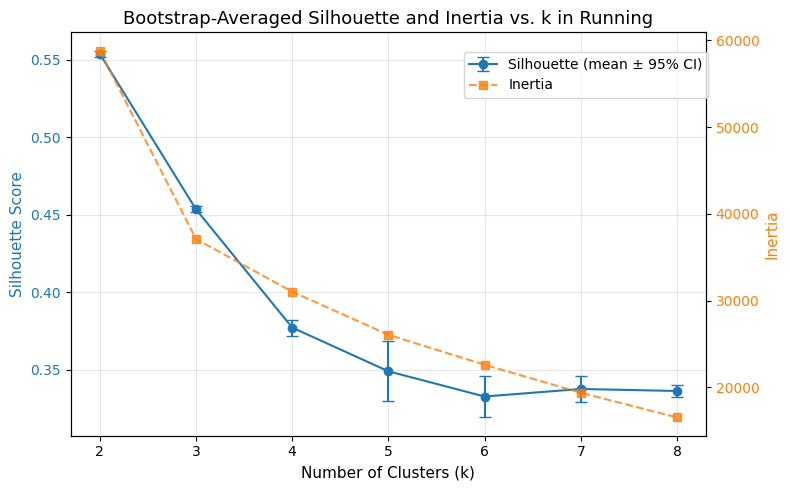

✅ Best k = 2, mean silhouette =0.5539


In [ ]:
best_k, summary_df = find_best_k_bootstrap(df = running_df, max_k = 8, pca_reduce=True, pca_components = 2, sample_size = 5000, output='../figure', Activity_type='Running')

In [105]:
#best_k = 5 # 假設已經用 find_best_k 找到
result_kmeans, lower, upper = kmeans_anomaly_detection(running_df, best_k=best_k,pca_reduce=True, pca_components = 2, return_with_input=False)

print(result_kmeans.head(5))


PCA enabled → reduced to 2 dimensions
95% CI for centroid distances: (0.6462, 5.6095)
          unique_log_id  cluster  distance_to_centroid  anomaly      PCA1  \
0  1_Running_2024-01-28        1              3.709270    False -8.553761   
1  1_Running_2024-01-30        1              3.556045    False -8.383628   
2  1_Running_2024-03-31        1              0.775751    False -4.497260   
3  1_Running_2024-04-06        1              1.625069    False -4.186312   
4  1_Running_2024-08-15        0              1.514757    False  3.882974   

       PCA2  
0  0.585336  
1 -0.665457  
2  0.670181  
3  1.466080  
4  0.791067  


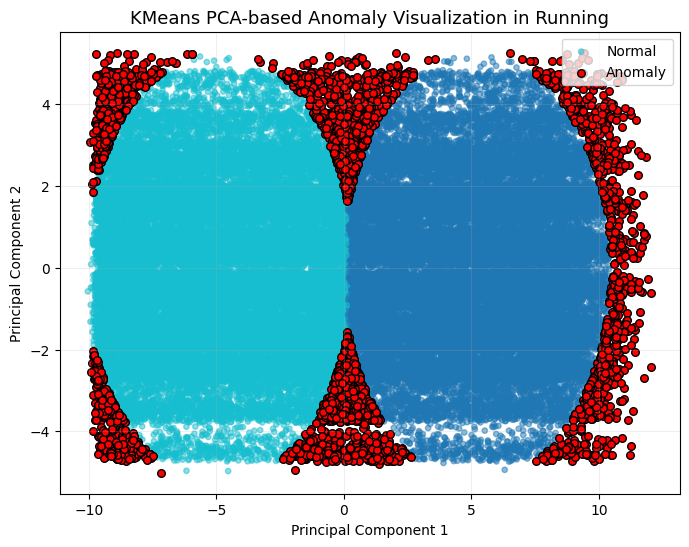

In [ ]:
vs_kmeans_anomalies(result_kmeans, output='../figure', Activity_type='Running')

### One-Class SVM

one class svm


In [107]:
ocsvm_df, svm_model = oneClassSVM_anomaly_detection(
    df=running_df,
    unique_key="unique_log_id",
    subsample=8000,
    nu=0.02,
    gamma="scale",
    return_with_input=True
)
print(ocsvm_df['anomaly'].value_counts())


Using subsample of 8,000 rows for OneClassSVM training (from 67,145)
anomaly
False    65775
True      1370
Name: count, dtype: int64
anomaly
False    65775
True      1370
Name: count, dtype: int64


PCA reduced data to 2D for visualization


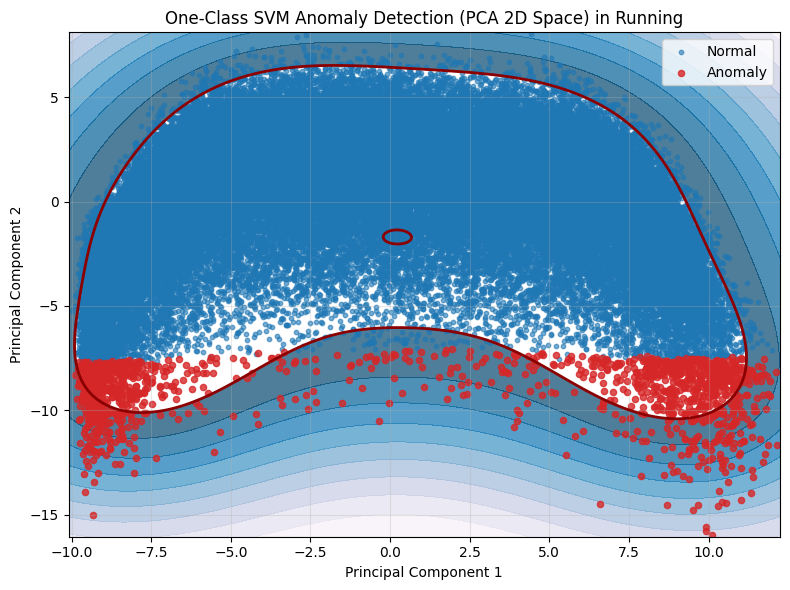

In [108]:
vs_oneClassSVM_results(
    df=ocsvm_df,
    model=svm_model,
    unique_key="unique_log_id",
    anomaly_col = "anomaly",
    pca_components=2,
    plot_boundary=True,
    output='./output',
    Activity_type = 'Running'
)


In [ ]:
result_kmeans = result_kmeans.loc[:, ['unique_log_id', 'anomaly', 'distance_to_centroid', 'cluster']]
ocsvm_df = ocsvm_df.loc[:,['anomaly', 'unique_log_id','svm_score']]

print("Output kmeans experiment data here: ")
result_kmeans.to_parquet("../data/pipeline/kMeans_running.parquet", index=False)


print("Output One-class SVM experiment data here: ")
ocsvm_df.to_parquet("../data/pipeline/oneClassSVM_running.parquet", index=False)

Output kmeans experiment data here: 
Output One-class SVM experiment data here: 


In [110]:
result_kmeans.shape, ocsvm_df.shape

((67145, 4), (67145, 3))

### Other experiment on swimming

In [111]:
swimming_df = activities_based(fitness_analaysis, exclude = ['unique_log_id', 'participant_id'],activity='Swimming', drop_original=True, onehot=True)

swimming_df.head()

,participant_id,age,height_cm,weight_kg,bmi,duration_minutes,calories_burned,daily_steps,avg_heart_rate,resting_heart_rate,...,health_condition_Asthma,health_condition_Diabetes,health_condition_Hypertension,health_condition_no illness,intensity_High,intensity_Low,intensity_Medium,smoking_status_Current,smoking_status_Former,smoking_status_Never
0,1,1.055936,-0.359675,-0.742675,-0.718611,-0.203064,-1.249937,-0.342335,-1.653364,-0.100605,...,0,0,0,1,0,1,0,0,0,1
1,1,1.055936,-0.359675,-0.612816,-0.507189,-1.539418,-1.279980,-0.521436,-0.306163,-0.100605,...,0,0,0,1,0,0,1,0,0,1
2,1,1.055936,-0.359675,-0.908801,-0.986756,0.027735,-0.268519,-1.568303,-1.092030,-0.100605,...,0,0,0,1,0,0,1,0,0,1
3,1,1.055936,-0.359675,-1.103005,-1.301311,-1.539418,-1.019604,-0.543824,-1.372697,-0.100605,...,0,0,0,1,0,1,0,0,0,1
4,1,1.055936,-0.359675,-0.473598,-0.285454,-1.060724,0.172117,1.123084,-0.474563,-0.100605,...,0,0,0,1,0,0,1,0,0,1


In [112]:
swimming_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68032 entries, 0 to 68031
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   participant_id                 68032 non-null  category
 1   age                            68032 non-null  float64 
 2   height_cm                      68032 non-null  float64 
 3   weight_kg                      68032 non-null  float64 
 4   bmi                            68032 non-null  float64 
 5   duration_minutes               68032 non-null  float64 
 6   calories_burned                68032 non-null  float64 
 7   daily_steps                    68032 non-null  float64 
 8   avg_heart_rate                 68032 non-null  float64 
 9   resting_heart_rate             68032 non-null  float64 
 10  blood_pressure_systolic        68032 non-null  float64 
 11  blood_pressure_diastolic       68032 non-null  float64 
 12  endurance_level                6

#### Kmeans methods

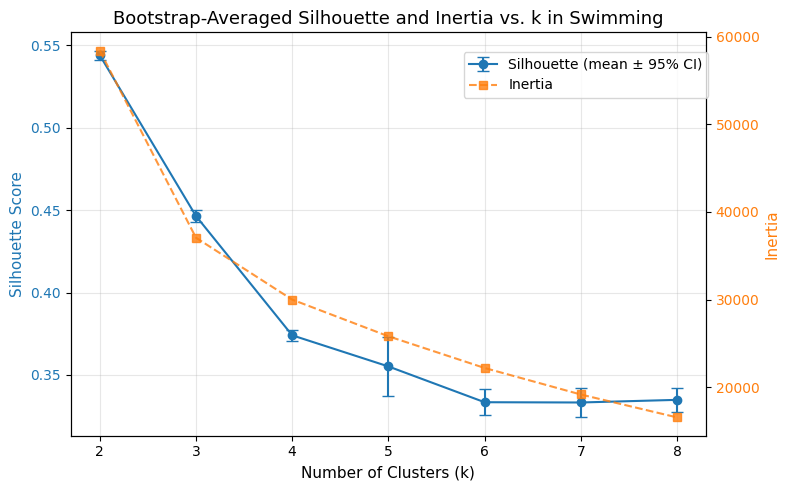

✅ Best k = 2, mean silhouette =0.5440


In [ ]:
best_k, summary_df = find_best_k_bootstrap(df = swimming_df, max_k = 8, pca_reduce=True, pca_components = 2, sample_size = 5000, output='../figure', Activity_type='Swimming')

In [114]:
#best_k = 5 # 假設已經用 find_best_k 找到
result_kmeans, lower, upper = kmeans_anomaly_detection(swimming_df, best_k=best_k,pca_reduce=True, pca_components = 2, return_with_input=False)

print(result_kmeans.head(5))


PCA enabled → reduced to 2 dimensions
95% CI for centroid distances: (0.6501, 5.6019)
           unique_log_id  cluster  distance_to_centroid  anomaly      PCA1  \
0  1_Swimming_2024-01-04        0              5.426103     True -9.471149   
1  1_Swimming_2024-01-05        0              4.861314    False -9.602728   
2  1_Swimming_2024-01-09        0              4.536503    False -9.040855   
3  1_Swimming_2024-02-02        0              4.368542    False -8.107325   
4  1_Swimming_2024-03-12        0              1.159969    False -5.754758   

       PCA2  
0 -2.682490  
1 -0.217758  
2  1.444046  
3  2.774144  
4  0.556306  


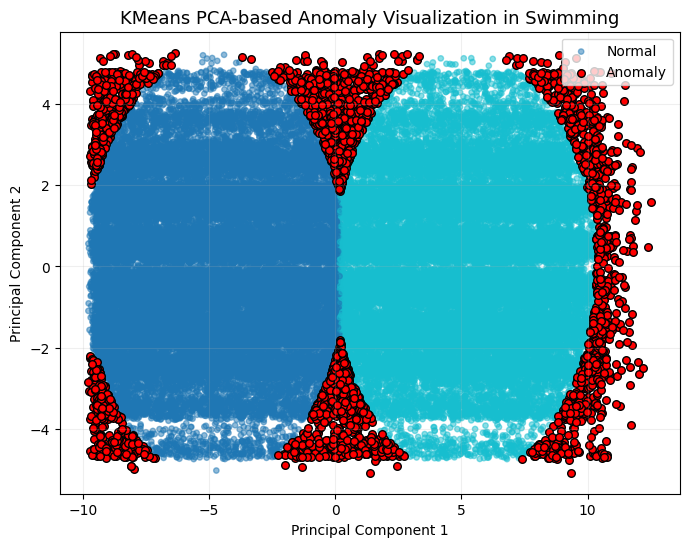

In [ ]:
vs_kmeans_anomalies(result_kmeans, output='../figure', Activity_type='Swimming')

#### One Class SVM

In [116]:
ocsvm_df, svm_model = oneClassSVM_anomaly_detection(
    df=swimming_df,
    unique_key="unique_log_id",
    subsample=8000,
    nu=0.02,
    gamma="scale",
    return_with_input=True
)
print(ocsvm_df['anomaly'].value_counts())


Using subsample of 8,000 rows for OneClassSVM training (from 68,032)
anomaly
False    66597
True      1435
Name: count, dtype: int64
anomaly
False    66597
True      1435
Name: count, dtype: int64


PCA reduced data to 2D for visualization


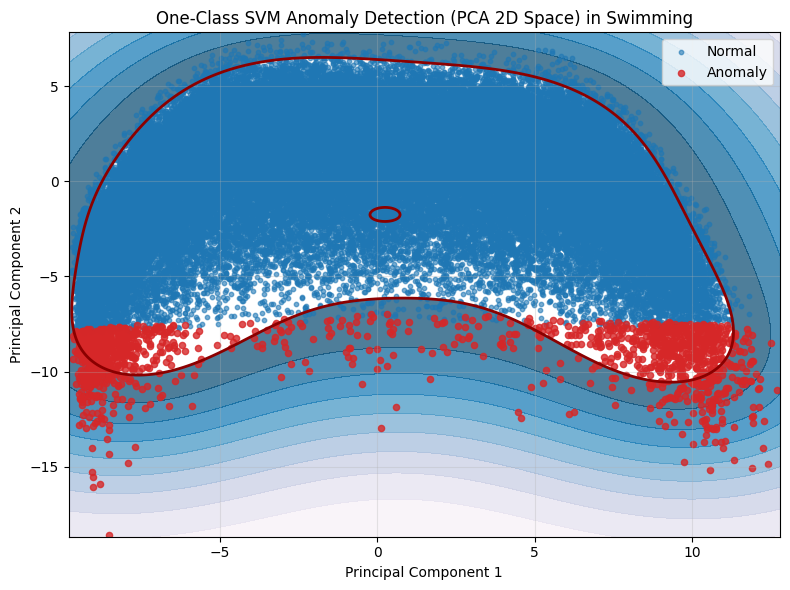

In [ ]:
vs_oneClassSVM_results(
    df=ocsvm_df,
    model=svm_model,
    unique_key="unique_log_id",
    anomaly_col = "anomaly",
    pca_components=2,
    plot_boundary=True,
    output='../figure',
    Activity_type = 'Swimming'
)


In [118]:
ocsvm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68032 entries, 0 to 68031
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   participant_id                 68032 non-null  category
 1   age                            68032 non-null  float64 
 2   height_cm                      68032 non-null  float64 
 3   weight_kg                      68032 non-null  float64 
 4   bmi                            68032 non-null  float64 
 5   duration_minutes               68032 non-null  float64 
 6   calories_burned                68032 non-null  float64 
 7   daily_steps                    68032 non-null  float64 
 8   avg_heart_rate                 68032 non-null  float64 
 9   resting_heart_rate             68032 non-null  float64 
 10  blood_pressure_systolic        68032 non-null  float64 
 11  blood_pressure_diastolic       68032 non-null  float64 
 12  endurance_level                6

In [119]:
result_kmeans.head(5)

,unique_log_id,cluster,distance_to_centroid,anomaly,PCA1,PCA2
0,1_Swimming_2024-01-04,0,5.426103,True,-9.471149,-2.682490
1,1_Swimming_2024-01-05,0,4.861314,False,-9.602728,-0.217758
2,1_Swimming_2024-01-09,0,4.536503,False,-9.040855,1.444046
3,1_Swimming_2024-02-02,0,4.368542,False,-8.107325,2.774144
4,1_Swimming_2024-03-12,0,1.159969,False,-5.754758,0.556306


In [ ]:
result_kmeans = result_kmeans.loc[:, ['unique_log_id', 'anomaly', 'distance_to_centroid', 'cluster']]
ocsvm_df = ocsvm_df.loc[:,['anomaly', 'unique_log_id','svm_score']]
print("Output kmeans experiment data here: ")
result_kmeans.to_parquet("../data/pipeline/kMeans_swimming.parquet", index=False)


print("Output One-class SVM experiment data here: ")
ocsvm_df.to_parquet("../data/pipeline/oneClassSVM_swimming.parquet", index=False)

Output kmeans experiment data here: 
Output One-class SVM experiment data here: 


In [121]:
ocsvm_df.shape, result_kmeans.shape

((68032, 3), (68032, 4))

## Convert dataframe to Tensor:

In [122]:
fitness_AE = fitness_analaysis.drop(columns=['age', 'height_cm', 'weight_kg', 'bmi', 'smoking_status', 'health_condition'])

fitness_AE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687699 entries, 0 to 687698
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   participant_id            687699 non-null  category
 1   activity_type             687699 non-null  category
 2   duration_minutes          687699 non-null  float64 
 3   intensity                 687699 non-null  category
 4   calories_burned           687699 non-null  float64 
 5   daily_steps               687699 non-null  float64 
 6   avg_heart_rate            687699 non-null  float64 
 7   resting_heart_rate        687699 non-null  float64 
 8   blood_pressure_systolic   687699 non-null  float64 
 9   blood_pressure_diastolic  687699 non-null  float64 
 10  endurance_level           687699 non-null  float64 
 11  sleep_hours               687699 non-null  float64 
 12  stress_level              687699 non-null  int32   
 13  hydration_level           687

In [123]:
swim_df_AE = activities_based(fitness_AE, exclude = ['participant_id', 'unique_log_id'], activity = 'Swimming', onehot=False)

swim_df_AE.head()

,participant_id,duration_minutes,intensity,calories_burned,daily_steps,avg_heart_rate,resting_heart_rate,blood_pressure_systolic,blood_pressure_diastolic,endurance_level,...,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,quarter_sin,quarter_cos,dayOfYear_sin,dayOfYear_cos
0,1,-0.203064,Low,-1.249937,-0.342335,-1.653364,-0.100605,-0.929296,-0.884543,-1.826298,...,0.500000,8.660254e-01,0.433884,-0.900969,0.724793,0.688967,1.0,6.123234e-17,0.068802,0.997630
1,1,-1.539418,Medium,-1.279980,-0.521436,-0.306163,-0.100605,-0.929296,-0.884543,-1.812942,...,0.500000,8.660254e-01,-0.433884,-0.900969,0.848644,0.528964,1.0,6.123234e-17,0.085965,0.996298
2,1,0.027735,Medium,-0.268519,-1.568303,-1.092030,-0.100605,-0.929296,-0.884543,-1.790682,...,0.500000,8.660254e-01,0.781831,0.623490,0.968077,-0.250653,1.0,6.123234e-17,0.154309,0.988023
3,1,-1.539418,Low,-1.019604,-0.543824,-1.372697,-0.100605,-0.929296,-0.884543,-1.608150,...,0.866025,5.000000e-01,-0.433884,-0.900969,0.394356,0.918958,1.0,6.123234e-17,0.538005,0.842942
4,1,-1.060724,Medium,0.172117,1.123084,-0.474563,-0.100605,-0.929296,-0.884543,-1.274249,...,1.000000,6.123234e-17,0.781831,0.623490,0.651372,-0.758758,1.0,6.123234e-17,0.945596,0.325342


In [124]:
swim_df_AE.shape, swimming_df.shape

((68032, 25), (68032, 38))

In [125]:
swim_df_AE['intensity'].unique()

['Low', 'Medium', 'High']
Categories (3, object): ['High', 'Low', 'Medium']

In [126]:
swim_df_AE['intensity_code'] = swim_df_AE['intensity'].map({'Low':0, 'Medium':1, 'High':2}).astype('int')

swim_df_AE.drop(columns=['intensity'], inplace=True)

swim_df_AE.head()

,participant_id,duration_minutes,calories_burned,daily_steps,avg_heart_rate,resting_heart_rate,blood_pressure_systolic,blood_pressure_diastolic,endurance_level,sleep_hours,...,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,quarter_sin,quarter_cos,dayOfYear_sin,dayOfYear_cos,intensity_code
0,1,-0.203064,-1.249937,-0.342335,-1.653364,-0.100605,-0.929296,-0.884543,-1.826298,1.081411,...,8.660254e-01,0.433884,-0.900969,0.724793,0.688967,1.0,6.123234e-17,0.068802,0.997630,0
1,1,-1.539418,-1.279980,-0.521436,-0.306163,-0.100605,-0.929296,-0.884543,-1.812942,-0.873188,...,8.660254e-01,-0.433884,-0.900969,0.848644,0.528964,1.0,6.123234e-17,0.085965,0.996298,1
2,1,0.027735,-0.268519,-1.568303,-1.092030,-0.100605,-0.929296,-0.884543,-1.790682,0.052675,...,8.660254e-01,0.781831,0.623490,0.968077,-0.250653,1.0,6.123234e-17,0.154309,0.988023,1
3,1,-1.539418,-1.019604,-0.543824,-1.372697,-0.100605,-0.929296,-0.884543,-1.608150,-1.284682,...,5.000000e-01,-0.433884,-0.900969,0.394356,0.918958,1.0,6.123234e-17,0.538005,0.842942,0
4,1,-1.060724,0.172117,1.123084,-0.474563,-0.100605,-0.929296,-0.884543,-1.274249,-0.153072,...,6.123234e-17,0.781831,0.623490,0.651372,-0.758758,1.0,6.123234e-17,0.945596,0.325342,1


In [127]:
swim_df_AE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68032 entries, 0 to 68031
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   participant_id            68032 non-null  category
 1   duration_minutes          68032 non-null  float64 
 2   calories_burned           68032 non-null  float64 
 3   daily_steps               68032 non-null  float64 
 4   avg_heart_rate            68032 non-null  float64 
 5   resting_heart_rate        68032 non-null  float64 
 6   blood_pressure_systolic   68032 non-null  float64 
 7   blood_pressure_diastolic  68032 non-null  float64 
 8   endurance_level           68032 non-null  float64 
 9   sleep_hours               68032 non-null  float64 
 10  stress_level              68032 non-null  int32   
 11  hydration_level           68032 non-null  float64 
 12  fitness_level             68032 non-null  float64 
 13  unique_log_id             68032 non-null  cate

In [128]:
feature_cols = [col for col in swim_df_AE.columns if col not in ['participant_id', 'unique_log_id', 'intensity']]

swim_X = swim_df_AE[feature_cols].values

swim_X.shape

(68032, 23)

In [129]:
X_train, X_temp = train_test_split(
    swim_X, test_size=0.3, random_state=42  # 30% 留給 val + test
)

X_val, X_test = train_test_split(
    X_temp, test_size=0.5, random_state=42  # 各取 15%
)

X_train.shape, X_val.shape

((47622, 23), (10205, 23))

In [130]:
model, history, mean_error = train_autoencoder(
    X_train, 
    X_val, 
    X_test, 
    ActivityAutoencoder, 
    input_dim = 23, 
    encoding_dim=8, 
    lr = 3e-4, 
    epochs = 100)

print(mean_error)
print(len(history))
print(model)

Epoch 10/100 | Train Loss: 0.610780 | Val Loss: 0.468585 | Val Recon Err Mean: 0.468591
Epoch 20/100 | Train Loss: 0.565842 | Val Loss: 0.442097 | Val Recon Err Mean: 0.442114
Epoch 30/100 | Train Loss: 0.548453 | Val Loss: 0.417625 | Val Recon Err Mean: 0.417658
Epoch 40/100 | Train Loss: 0.535392 | Val Loss: 0.417142 | Val Recon Err Mean: 0.417182
Epoch 50/100 | Train Loss: 0.531115 | Val Loss: 0.414037 | Val Recon Err Mean: 0.414076
Epoch 60/100 | Train Loss: 0.526151 | Val Loss: 0.405897 | Val Recon Err Mean: 0.405933
Epoch 70/100 | Train Loss: 0.522917 | Val Loss: 0.407609 | Val Recon Err Mean: 0.407643
Epoch 80/100 | Train Loss: 0.526651 | Val Loss: 0.412389 | Val Recon Err Mean: 0.412423
[Early Stopping] Epoch 82
Final Test Reconstruction Error Mean: 0.41000253
0.41000253
2
ActivityAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=23, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU

In [131]:
feature_cols

['duration_minutes',
 'calories_burned',
 'daily_steps',
 'avg_heart_rate',
 'resting_heart_rate',
 'blood_pressure_systolic',
 'blood_pressure_diastolic',
 'endurance_level',
 'sleep_hours',
 'stress_level',
 'hydration_level',
 'fitness_level',
 'month_sin',
 'month_cos',
 'weekday_sin',
 'weekday_cos',
 'day_sin',
 'day_cos',
 'quarter_sin',
 'quarter_cos',
 'dayOfYear_sin',
 'dayOfYear_cos',
 'intensity_code']

In [ ]:
autoencoder_df = compute_reconstruction_error(model, swim_df_AE, feature_cols = feature_cols, result_cols = ['unique_log_id', 'reconstruction_error', 'anomaly'])

autoencoder_df = autoencoder_df[['unique_log_id', 'reconstruction_error', 'anomaly']]

autoencoder_df.to_parquet("../data/pipeline/autoencoder_swimming.parquet", index=False)

autoencoder_df.head()

,unique_log_id,reconstruction_error,anomaly
0,1_Swimming_2024-01-04,0.358448,False
1,1_Swimming_2024-01-05,0.283075,False
2,1_Swimming_2024-01-09,0.454732,False
3,1_Swimming_2024-02-02,0.292561,False
4,1_Swimming_2024-03-12,0.255176,False


## Experiment on Running data


In [133]:
running_df_AE = activities_based(fitness_AE, exclude = ['participant_id', 'unique_log_id'], activity = 'Running', onehot=False)

running_df_AE['intensity_code'] = running_df_AE['intensity'].map({'Low':0, 'Medium':1, 'High':2}).astype('int')

running_df_AE.drop(columns=['intensity'], inplace=True)

running_df_AE.head()

,participant_id,duration_minutes,calories_burned,daily_steps,avg_heart_rate,resting_heart_rate,blood_pressure_systolic,blood_pressure_diastolic,endurance_level,sleep_hours,...,month_cos,weekday_sin,weekday_cos,day_sin,day_cos,quarter_sin,quarter_cos,dayOfYear_sin,dayOfYear_cos,intensity_code
0,1,-1.539418,-0.919459,-0.520950,-0.137763,-0.100605,-0.929296,-0.884543,-1.666026,-0.153072,...,8.660254e-01,-0.781831,0.623490,-5.712682e-01,0.820763,1.000000e+00,6.123234e-17,0.463550,0.886071,1
1,1,-1.539418,-0.158360,-0.108238,-0.642963,-0.100605,-0.929296,-0.884543,-1.643766,0.875664,...,8.660254e-01,0.781831,0.623490,-2.012985e-01,0.979530,1.000000e+00,6.123234e-17,0.493776,0.869589,0
2,1,0.352563,-0.228461,1.690076,-0.867497,-0.100605,-0.929296,-0.884543,-1.087265,-0.564567,...,6.123234e-17,-0.781831,0.623490,-2.449294e-16,1.000000,1.000000e+00,6.123234e-17,0.999991,0.004304,1
3,1,-0.277148,0.362392,0.945929,-0.699097,-0.100605,-0.929296,-0.884543,-1.056101,0.052675,...,-5.000000e-01,-0.974928,-0.222521,9.377521e-01,0.347305,1.224647e-16,-1.000000e+00,0.995105,-0.098820,1
4,1,0.825558,-0.939488,-1.028566,-1.428830,-0.100605,-0.929296,-0.884543,0.025735,-0.976061,...,-5.000000e-01,0.433884,-0.900969,1.011683e-01,-0.994869,-1.000000e+00,-1.836970e-16,-0.705584,-0.708627,0


In [134]:
running_df_AE.shape

(67145, 25)

In [135]:
feature_cols = [col for col in running_df_AE.columns if col not in ['participant_id', 'unique_log_id', 'intensity']]

running_X = running_df_AE[feature_cols].values

print(running_X.shape)

run_train, run_temp = train_test_split(
    running_X, test_size=0.3, random_state=42  # 30% 留給 val + test
)

run_val, run_test = train_test_split(
    run_temp, test_size=0.5, random_state=42  # 各取 15%
)

run_train.shape, run_val.shape

(67145, 23)


((47001, 23), (10072, 23))

In [136]:
model, history, mean_error = train_autoencoder(
    run_train, 
    run_val, 
    run_test, 
    ActivityAutoencoder, 
    input_dim = 23, 
    encoding_dim=8, 
    lr = 3e-4, 
    epochs = 100)

print(mean_error)
print(len(history))
print(model)

Epoch 10/100 | Train Loss: 0.622780 | Val Loss: 0.477102 | Val Recon Err Mean: 0.477043
Epoch 20/100 | Train Loss: 0.586265 | Val Loss: 0.450249 | Val Recon Err Mean: 0.450162
Epoch 30/100 | Train Loss: 0.573760 | Val Loss: 0.444333 | Val Recon Err Mean: 0.444245
Epoch 40/100 | Train Loss: 0.567309 | Val Loss: 0.442204 | Val Recon Err Mean: 0.442113
Epoch 50/100 | Train Loss: 0.562561 | Val Loss: 0.451807 | Val Recon Err Mean: 0.451727
[Early Stopping] Epoch 59
Final Test Reconstruction Error Mean: 0.45499915
0.45499915
2
ActivityAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=23, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in

In [137]:
feature_cols

['duration_minutes',
 'calories_burned',
 'daily_steps',
 'avg_heart_rate',
 'resting_heart_rate',
 'blood_pressure_systolic',
 'blood_pressure_diastolic',
 'endurance_level',
 'sleep_hours',
 'stress_level',
 'hydration_level',
 'fitness_level',
 'month_sin',
 'month_cos',
 'weekday_sin',
 'weekday_cos',
 'day_sin',
 'day_cos',
 'quarter_sin',
 'quarter_cos',
 'dayOfYear_sin',
 'dayOfYear_cos',
 'intensity_code']

In [138]:
running_X.shape

(67145, 23)

In [ ]:
autoencoder_running_df = compute_reconstruction_error(model, running_df_AE, feature_cols = feature_cols)

autoencoder_running_df = autoencoder_running_df[['unique_log_id', 'reconstruction_error', 'anomaly']]

autoencoder_running_df.to_parquet("../data/pipeline/autoencoder_running.parquet", index=False)

autoencoder_running_df.head()

,unique_log_id,reconstruction_error,anomaly
0,1_Running_2024-01-28,0.266641,False
1,1_Running_2024-01-30,0.253318,False
2,1_Running_2024-03-31,0.292586,False
3,1_Running_2024-04-06,0.302421,False
4,1_Running_2024-08-15,0.332616,False
